# Parabolic Stark Diamond Manifold
The external electric field does not mix states with different magnetic quantum number $m$. So we will construct the manifold of states with the same $m$.


In [1]:
# Import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from arc import *
# https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/installation.html
import scipy.constants as cts
from numpy.linalg import eig
from numba import jit
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
import sys

In [2]:
# Some experimental parameters and constants
# Physical constants
a0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
h = cts.h  # Planck's constant in J*s
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second

In [3]:
# Get the energy level of the target state



def getEnergyLevel(StarkMap, eFieldList, stateIndex=0):
    """ 
    find the energy level of the target state

    Target states are specified during the initialization procedure of the StarkMap
    """
    StarkMap.diagonalise(eFieldList)
    # find initial states
    #initalState = np.zeros(len(StarkMap.basisStates))   
    #initalState[StarkMap.indexOfCoupledState] = 1
    #initalState0 = initalState
    minEfield = min(eFieldList)
    energyList = []
    overlapWithInitials = []
    m = StarkMap.mat1 + StarkMap.mat2 * minEfield
    ev, egvector = eigh(m)
    initalState = egvector[:, stateIndex]
    initalState0 = initalState
    for eField in eFieldList:
        # find first state in electric field
        m = StarkMap.mat1 + StarkMap.mat2 * eField
        # diagonalise the matrices
        ev, egvector = eigh(m)

        # ----------------------Track the state ----------------------
        # find state that has largest overlap to the selected state for 
        # previous value of eField, starting with the initial state for zero field
        # i.e. it is adiabatically connected to the initial state
        
        maxOverlap = 0  # overlap with previous selected state
        eigenvectorIndex = 0
        for i in range(len(ev)):
            if ( abs(np.vdot(egvector[:, i], initalState)) > maxOverlap):
                maxOverlap = abs(np.vdot(egvector[:, i], initalState))
                eigenvectorIndex= i
        
        maxOverlap0 = maxOverlap
        
            
        overlapWithInitial = abs(np.vdot(egvector[:, eigenvectorIndex], initalState0))
        overlapWithInitials.append(overlapWithInitial)

        # save reference point for search of closest state for higher eField in next step
        
        initalState = egvector[:, eigenvectorIndex] 

        energy = ev[eigenvectorIndex]
    

        energyList.append(energy)
    
    overlapWithInitials = np.array(overlapWithInitials)
    energyList = np.array(energyList) # in the unit of GHz, negative sign because it is ionisation energy
    return energyList, overlapWithInitials
    

In [35]:
# Test the code
atom = Rubidium()
n0 = 52
l0 = 27
j0 = l0+0.5
mj0 = 5.5
nmin = n0
nmax = n0 + 1
maxL = n0 - 1


eFieldList = np.linspace(5, 500, 100) # in V/m



stMap = StarkMap(atom)
stMap.defineBasis(
    n0, l0, j0, mj0, nmin, nmax, maxL, progressOutput=False, mlBasis=True      
)

energyLevels, overlaps = getEnergyLevel(stMap, eFieldList,l0)
originalEnergy = (
atom.getEnergy(n0, l0, j0) * e / h * 1e-9)
originalEnergys = np.full(len(eFieldList), originalEnergy)
energyShifts = energyLevels - originalEnergys

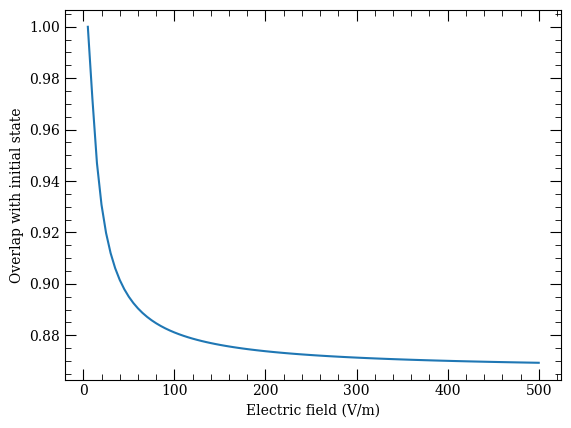

In [36]:
plt.plot(eFieldList, overlaps)
plt.xlabel('Electric field (V/m)')
plt.ylabel('Overlap with initial state')
plt.show()

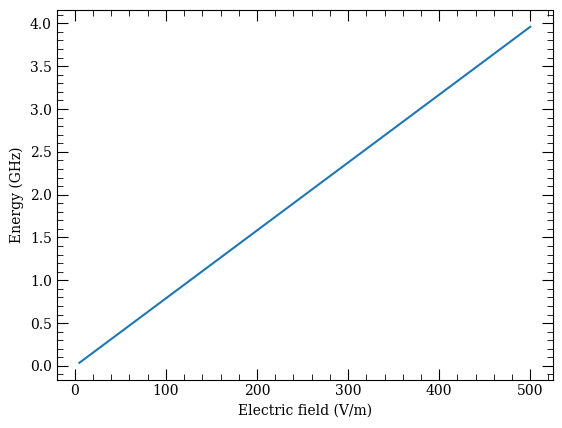

In [37]:
# Plot the energy levels
plt.plot(eFieldList, energyShifts, '-')
#plt.plot(eFieldList, energyLevels, '-')
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy (GHz)')
plt.show()

## Construct the manifold of states with the same $m$

In [9]:
# Choose the atom here
atom = Rubidium87()
n0 = 52
ml0 = 3
eFieldList = np.linspace(2, 1000, 500)

l0s = np.arange(0, n0)
j0s = l0s + 0.5
q = 1
mj0 = ml0 + 0.5
nmin = n0
nmax = n0 + 1 # Suppose the field is weak enough that the manifold is not mixed
maxL = n0-1

energyList = []
overlapList = []

i=0
for l0 in np.arange(ml0, n0):
    stMap = StarkMap(atom)
    stMap.defineBasis(
        n0, l0, l0+0.5, mj0, nmin, nmax, maxL, progressOutput=False, mlBasis=True,
    )

    energyLevels, overlaps = getEnergyLevel(stMap, eFieldList,i)
    energyList.append(energyLevels)
    overlapList.append(overlaps)
    i +=1





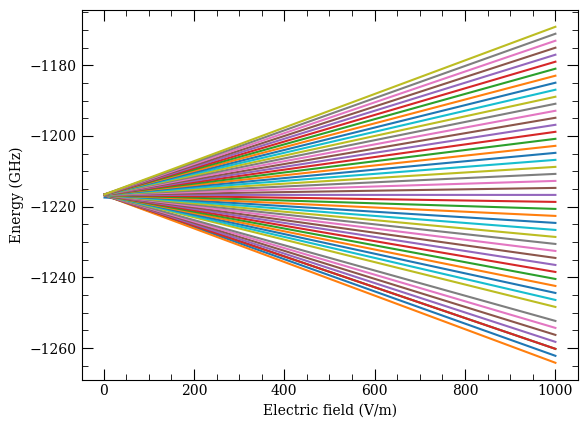

In [10]:
# Plot the energy levels
for l0 in range(len(energyList)):
    plt.plot(eFieldList, energyList[l0], label="l0 = {}".format(l0))
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy (GHz)')
#plt.legend()
plt.show()

In [ ]:
# Choose the atom here
atom = Rubidium87()
n0 = 52
ml0 = 2
eFieldList = np.linspace(2, 30, 50)

l0s = np.arange(0, n0)
j0s = l0s + 0.5
q = 1
mj0 = ml0 + 0.5
nmin = n0
nmax = n0 + 1 # Suppose the field is weak enough that the manifold is not mixed
maxL = n0-1

energyList = []
overlapList = []

i=0
for l0 in np.arange(ml0, n0):
    stMap = StarkMap(atom)
    stMap.defineBasis(
        n0, l0, l0+0.5, mj0, nmin, nmax, maxL, progressOutput=False, mlBasis=True, Bz=18
    )

    energyLevels, overlaps = getEnergyLevel(stMap, eFieldList,i)
    energyList.append(energyLevels)
    overlapList.append(overlaps)
    i +=1


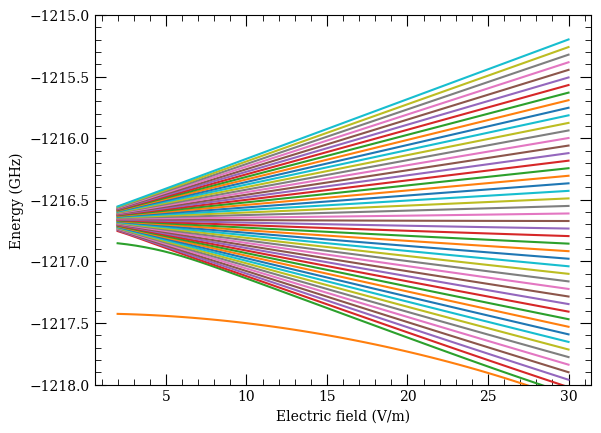

In [ ]:
# Plot the energy levels
ax = plt.subplot(111)
for l0 in range(len(energyList)):
    plt.plot(eFieldList, energyList[l0], label="l0 = {}".format(l0))
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy (GHz)')
#plt.legend()
ax.set_ylim([-1218, -1215])
plt.show()

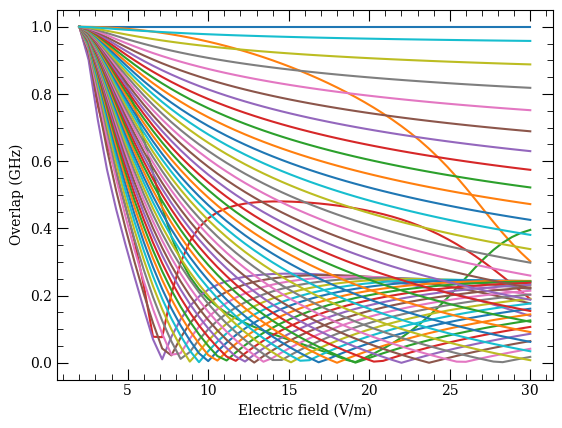

In [ ]:
# Plot the overlapList
# The graph should be continuous
for l0 in range(len(energyList)):
    plt.plot(eFieldList, overlapList[l0], label="l0 = {}".format(l0))
plt.xlabel('Electric field (V/m)')
plt.ylabel('Overlap (GHz)')
#plt.legend()
plt.show()

# Construct the Diamond manifold with different ms

In [11]:
# Construct the Diamond manifold with different ms
atom = Rubidium()
n0 = 50
eField = 240 # V/m
ml0s = np.arange(0, 50)

eFieldList = [eField]
stepEnergys = []
for ml0 in ml0s:
    
    l0s = np.arange(0, n0)
    j0s = l0s + 0.5
    q = 1
    mj0 = ml0 + 0.5
    nmin = n0
    nmax = n0 + 1 # Suppose the field is weak enough that the manifold is not mixed
    maxL = n0-1

    energyList = []
    overlapList = []

    i=0
    for l0 in np.arange(ml0, n0):
        stMap = StarkMap(atom)
        stMap.defineBasis(
            n0, l0, l0+0.5, mj0, nmin, nmax, maxL, progressOutput=False, mlBasis=True, Bz=18
        )

        energyLevels, overlaps = getEnergyLevel(stMap, eFieldList,i)
        energyList.append(energyLevels)
        overlapList.append(overlaps)
        i +=1
    stepEnergys.append(energyList)

stepEnergys = np.array(stepEnergys ,dtype=object)
    


KeyboardInterrupt: 

In [ ]:
stepEnergys = np.array(stepEnergys ,dtype=object)

In [ ]:
# Save the dme and energy shifts
np.savez('data/parabolic_quantum_number.npz', n0, eField, eFieldList, ml0s, stepEnergys, 
         n0=n0, ml0s=ml0s, eField = eField, eFieldList=eFieldList, stepEnergys=stepEnergys)

In [4]:
fileName = 'data/parabolic_quantum_number.npz'
stepEnergys = np.load(fileName, allow_pickle=True)['stepEnergys']
ml0s = np.load(fileName)['ml0s']
eFieldList = np.load(fileName)['eFieldList']
n0 = np.load(fileName)['n0']
eField = np.load(fileName)['eField']


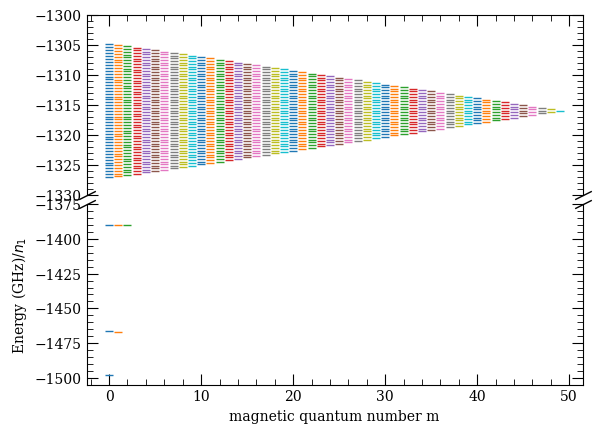

In [5]:
# Diamond manifold
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
#ax1.set_ylim(-1320, 1310)

for ml0 in ml0s:
    ax1.plot(np.full(len(stepEnergys[ml0]),ml0), stepEnergys[ml0], '_', label="ml0 = {}".format(ml0))
    ax2.plot(np.full(len(stepEnergys[ml0]),ml0), stepEnergys[ml0], '_', label="ml0 = {}".format(ml0))
ax1.set_ylim(-1330, -1300)
ax2.set_ylim(-1505, -1375)
# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.xlabel('magnetic quantum number m') 
plt.ylabel(r'Energy (GHz)/$n_1$')
plt.show()

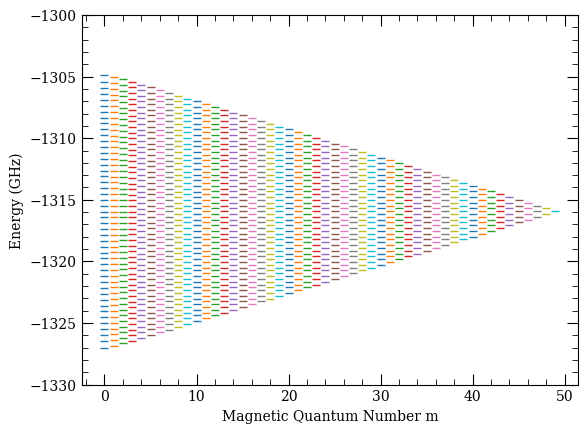

In [6]:
# Half Diamond manifold for m >= 2
fig0, ax0 = plt.subplots(1, 1)
ax0.set_ylim(-1330, -1300)

for ml0 in np.arange(0, len(ml0s)):
    plt.plot(np.full(len(stepEnergys[ml0]),ml0), stepEnergys[ml0], '_', label="ml0 = {}".format(ml0))

plt.xlabel('Magnetic Quantum Number m')
plt.ylabel('Energy (GHz)')
plt.show()
    


# Adiabatic Rapid Passage Path
ARP can follow the steps with increasing m.

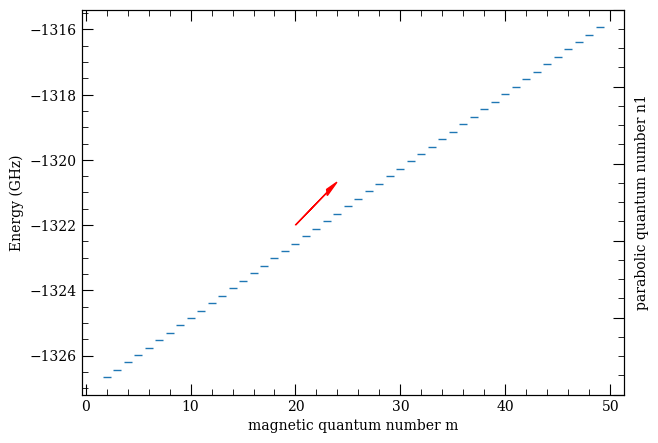

In [23]:
ARPsteps = []
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
ARPsteps.append(stepEnergys[2][1])
for ml0 in np.arange(3, len(ml0s)):
    ARPsteps.append(stepEnergys[ml0][0])
axes.plot(np.arange(2, len(ml0s)), ARPsteps, '_')
axes.tick_params(axis="y")
axes2=axes.twinx()
axes2.set_ylabel('parabolic quantum number n1')
axes2.set_yticklabels([])
axes.set_xlabel('magnetic quantum number m')
axes.set_ylabel('Energy (GHz)')
x = 20  # start point x coordinate
y = -1322  # start point y coordinate
dx = 3  # width of arrow
dy = 1  # height of arrow
axes.arrow(x, y, dx, dy, head_width=0.2, head_length=1, fc='red', ec='red')
plt.show()

# Calculate the coupling between each two steps 

In [22]:
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
import sys



class MatrixElementsEfield:
    def __init__(self, StarkMap1, StarkMap2, progressOutput=False):
        """
        calculates dipolar coupling between the two original target states
        of the two Stark Maps

        Note:
            StarkMaps have to have **defined basis**
            AND
            StarkMaps have to be calculated **for the same atom**
        """
        # save pointers to Stark maps for later
        self.StarkMap1 = StarkMap1
        self.StarkMap2 = StarkMap2

        # construct and save CSV sparce matrix of couplings
        matrixDMEcoupling = [[], [], []]

        for i in range(len(StarkMap1.basisStates)):
            if progressOutput:
                sys.stdout.write(
                    "\r%d%%"
                    % (float(i) / float(len(StarkMap1.basisStates) - 1) * 100)
                )
                sys.stdout.flush()
            for j in range(len(StarkMap2.basisStates)):
                # if dipole coupled, add to coupling
                dl = abs(
                    StarkMap1.basisStates[i][1] - StarkMap2.basisStates[j][1]
                )
                dj = abs(
                    StarkMap1.basisStates[i][2] - StarkMap2.basisStates[j][2]
                )
                if dl == 1 and (dj < 1.1):
                    dme = StarkMap1.atom.getDipoleMatrixElement(
                        StarkMap1.basisStates[i][0],
                        StarkMap1.basisStates[i][1],
                        StarkMap1.basisStates[i][2],
                        StarkMap1.basisStates[i][3],
                        StarkMap2.basisStates[j][0],
                        StarkMap2.basisStates[j][1],
                        StarkMap2.basisStates[j][2],
                        StarkMap2.basisStates[j][3],
                        q,
                    )
                    matrixDMEcoupling[0].append(dme)
                    matrixDMEcoupling[1].append(i)
                    matrixDMEcoupling[2].append(j)

        self.matrixDMEcoupling = csr_matrix(
            (
                matrixDMEcoupling[0],
                (matrixDMEcoupling[1], matrixDMEcoupling[2]),
            ),
            shape=(len(StarkMap1.basisStates), len(StarkMap2.basisStates)),
        )

    def getDipolarCoupling2(self, eFieldList):
        """
        find dipolar coupling and transition frequency between target states and energy shifts of two states

        Target states are specified during the initialization procedure of the StarkMap1 and StarkMap2
        """
        self.StarkMap1.diagonalise(eFieldList)
        self.StarkMap2.diagonalise(eFieldList)

        minEfield = min(eFieldList)
        
        
        # ----------------------Track the lowest energy state ----------------------
        m1 = self.StarkMap1.mat1 + self.StarkMap1.mat2 * minEfield
        ev1, egvector1 = eigh(m1)
        # stateIndex is the index of the minimum energy state
        stateIndex1 = np.argmin(ev1)
        initalState1 = egvector1[:, stateIndex1]
        # find initial states

        m2 = self.StarkMap2.mat1 + self.StarkMap2.mat2 * minEfield
        ev2, egvector2 = eigh(m2)
        stateIndex2 = np.argmin(ev2)
        initalState2 = egvector2[:, stateIndex2]
        
        # ----------------------Track the lowest energy state ----------------------
        # Coupling and energy lists
        couplingList = []
        energy1List = []
        energy2List = []

        for eField in eFieldList:
            # find first state in electric field
            m1 = self.StarkMap1.mat1 + self.StarkMap1.mat2 * eField
            # diagonalise the matrices
            ev1, egvector1 = eigh(m1)

            m2 = self.StarkMap2.mat1 + self.StarkMap2.mat2 * eField
            ev2, egvector2 = eigh(m2)

            # ----------------------Track the state ----------------------
            # find state that has largest overlap to the selected state for 
            # previous value of eField, starting with the initial state for zero field
            # i.e. it is adiabatically connected to the initial state

            maxOverlap1 = 0  # overlap with previous selected state
            eigenvectorIndex1 = 0
            for i in range(len(ev1)):
                if ( abs(np.vdot(egvector1[:, i], initalState1)) > maxOverlap1 ):
                    maxOverlap1 = abs(np.vdot(egvector1[:, i], initalState1))
                    eigenvectorIndex1= i

            # save reference point for search of closest state for higher eField in next step
            
            initalState1 = egvector1[:, eigenvectorIndex1] 

            energy1 = ev1[eigenvectorIndex1]
            state1composition = egvector1[:, eigenvectorIndex1]

            # Do the same thing for the second Stark map
            maxOverlap2 = 0
            eigenvectorIndex2 = 0
            for i in range(len(ev2)):
                if ( abs(np.vdot(egvector2[:, i], initalState2)) > maxOverlap2 ):
                    maxOverlap2 = abs(np.vdot(egvector2[:, i], initalState2))
                    eigenvectorIndex2= i
            
            initalState2 = egvector2[:, eigenvectorIndex2]
            energy2 = ev2[eigenvectorIndex2]
            state2composition = egvector2[:, eigenvectorIndex2]

            # ----------------------Calculate the coupling ----------------------
            
            # find coupling between the states

            coupling = self.matrixDMEcoupling.dot(state2composition).dot(
                state1composition
            )

            couplingList.append(np.abs(coupling))
            energy1List.append(energy1)
            energy2List.append(energy2)
        
        couplingList = np.array(couplingList) # in the unit of a0e
        energy1List = -1*np.array(energy1List) # in the unit of GHz, negative sign because it is ionisation energy
        energy2List = -1*np.array(energy2List) # in the unit of GHz
        transitionFrequency = np.abs(energy2List - energy1List) # in the unit of GHz
        
        # Note energy1List and energy2List are ionisation energy so should be negative
        return couplingList, transitionFrequency, energy1List, energy2List

  

In [29]:
atom = Rubidium()
n0 = 50
l0 = n0-1
j0 = l0+0.5
mj0 = 8.5
eFieldList = np.linspace(3, 100, 500)
nmin = n0
nmax = n0 + 1
maxL = n0 - 1
q = 1

stMap1 = StarkMap(atom)
stMap1.defineBasis(
    n0, l0, j0, mj0, nmin, nmax, maxL, progressOutput=False, mlBasis=True      
)

stMap2 = StarkMap(atom)
stMap2.defineBasis(
    n0, l0, j0, mj0+1, nmin, nmax, maxL, progressOutput=False, mlBasis=True      
)

matrixElements = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)
couplingList, transitionFrequency, energy1List, energy2List = matrixElements.getDipolarCoupling2(eFieldList)



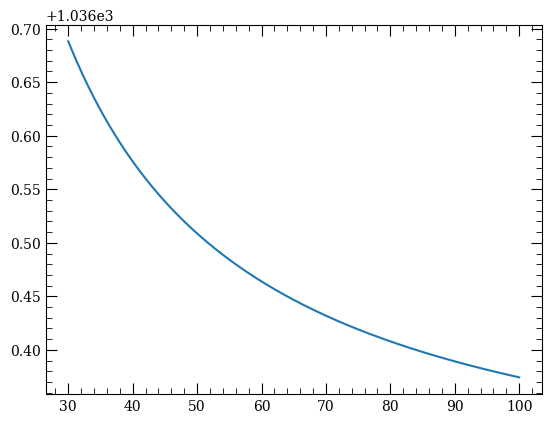

In [30]:
plt.plot(eFieldList, couplingList)

In [31]:
# We start from mj = 3.5 for Rubdium
atom = Rubidium()
eFieldList = np.linspace(50, 500, 300)
n0 = 50
l0 = n0-1
j0 = l0 + 0.5

mj0s = np.arange(3.5, j0, 1)

minn = n0
maxn = n0 + 1
maxL = n0 - 1
q = 1

dipoleMatrixElements = []
transitionFrequencies = []
energyShifts = []
for mj0 in mj0s:
    stMap1 = StarkMap(atom)
    stMap1.defineBasis(
        n0, l0, j0, mj0, minn, maxn, maxL, progressOutput=False, mlBasis=True
    )

    stMap2 = StarkMap(atom)
    stMap2.defineBasis(
        n0, l0, j0, mj0+1, minn, maxn, maxL, progressOutput=False, mlBasis=True
    )

    matrixElements = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)
    couplingList, transitionFrequency, energy1List, energy2List = matrixElements.getDipolarCoupling2(eFieldList)
    dipoleMatrixElements.append(couplingList)
    transitionFrequencies.append(transitionFrequency)
    energyOfOriginalState = -(
        atom.getEnergy(n0, l0, j0) * e / h * 1e-9   
    )
    energyShifts.append(-energy1List + energyOfOriginalState)
    if mj0 == j0-1:
        # include the last state
        energyShifts.append(-energy2List + energyOfOriginalState)

dipoleMatrixElements = np.array(dipoleMatrixElements)
transitionFrequencies = np.array(transitionFrequencies)
energyShifts = np.array(energyShifts)

In [6]:
# Save the dme and energy shifts
np.savez('data/parabolic_stark_diamond50.npz', n0, mj0s, eFieldList, dipoleMatrixElements, transitionFrequencies, energyShifts,
         n0=n0, mj0s=mj0s, eFieldList=eFieldList, dipoleMatrixElements=dipoleMatrixElements, 
         transitionFrequencies=transitionFrequencies, energyShifts=energyShifts)

In [24]:
# Load the data
fileName = 'data/parabolic_stark_diamond50.npz'
n0 = np.load(fileName)['n0']
mj0s = np.load(fileName)['mj0s']
eFieldList = np.load(fileName)['eFieldList']
dipoleMatrixElements = np.load(fileName)['dipoleMatrixElements']
transitionFrequencies = np.load(fileName)['transitionFrequencies']
energyShifts = np.load(fileName)['energyShifts']
    

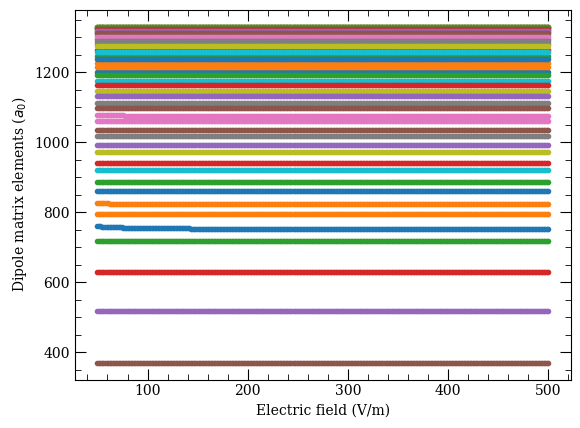

In [29]:
# Plot the dipole matrix elements
for i in range(len(dipoleMatrixElements)):
    plt.plot(eFieldList,dipoleMatrixElements[i],".",label = f'state {i} and {i+1}')
plt.xlabel('Electric field (V/m)')
plt.ylabel(r'Dipole matrix elements ($a_0$)')
plt.show()


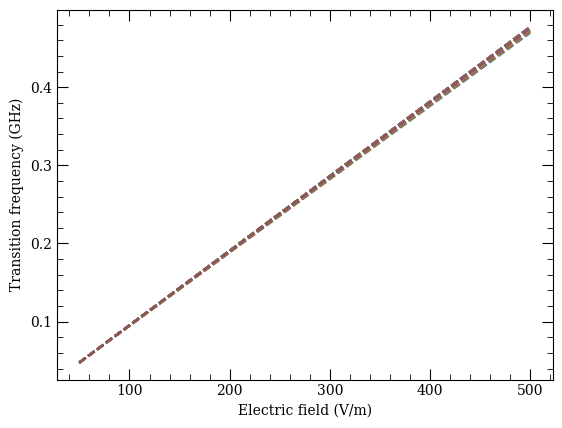

In [30]:
# Plot the transition frequencies
for i in range(len(transitionFrequencies)):
    plt.plot(eFieldList,transitionFrequencies[i],"--",label = f'state {i} and {i+1}')
plt.xlabel('Electric field (V/m)')
plt.ylabel('Transition frequency (GHz)')
plt.show()

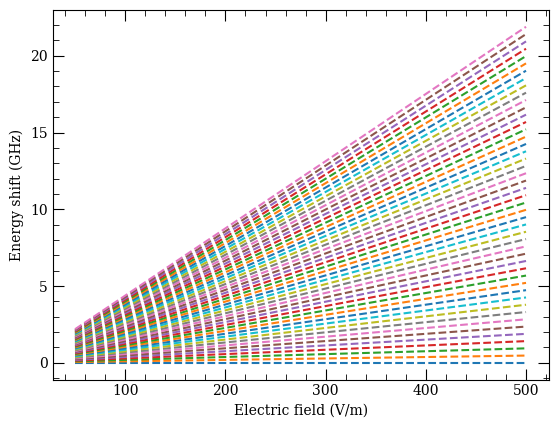

-2.1905241753654536
-2.142457425059092


In [31]:
# Plot the energy shifts
for i in range(len(energyShifts)):
    plt.plot(eFieldList,energyShifts[i]-energyShifts[0],"--",label = f'state {i}')
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy shift (GHz)')

plt.show()
print(energyShifts[0][0])
print(energyShifts[1][0])

In [32]:
# Calculate the Rabi frequency
E0 = 10 # electric field in V/m
rabiFrequencies = E0*dipoleMatrixElements/hbar*a0*e*(1e-9) # in GHz

# Construct the whole ARP map
We start from the state with $m$ equal to 3.

In [36]:
atom = Rubidium()
di = len(mj0s) # dimension of the Hamiltonian matrix
Er = 250 # The electric field at resonance in V/m

# resonance laser energy in GHz
laserEnergy = np.interp(Er, eFieldList, transitionFrequencies[0])


hamiltonian_matrix = np.zeros((di,di),dtype = complex)
energys = [[] for i in range(di)]
    
# Diagonal elements are energy shifts
minEfield = min(eFieldList)
initialStates = []
for m in range(len(eFieldList)):

    diagonals = [(energyShifts[n][m]-energyShifts[0][m]-laserEnergy*n) for n in range(di)]
    for i in range(di):
        hamiltonian_matrix[i,i] = diagonals[i]
        hamiltonian_matrix[0,0] = 0
    
        if i < di-1:
            hamiltonian_matrix[i+1,i] = hamiltonian_matrix[i, i+1]=0.5*rabiFrequencies[i][m]
            #hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0
    


    w, v = eig(hamiltonian_matrix)
    
    #----------------------Track the state ----------------------
    for i in range(di):
        if m==0:
            w_sorted_indices = np.argsort(w)
            initialState = v[:,w_sorted_indices[i]]
            initialStates.append(initialState)
            energys[i].append(w[w_sorted_indices[i]])
        else:
            maxOverlap = 0
            eigenvectorIndex = 0
            for j in range(di):
                overlap = np.abs(np.vdot(v[:,w_sorted_indices[j]],initialStates[i]))
                if overlap > maxOverlap:
                    maxOverlap = overlap
                    eigenvectorIndex = j
            energys[i].append(w[w_sorted_indices[eigenvectorIndex]])
            initialStates[i] = v[:,w_sorted_indices[eigenvectorIndex]]
    #--------------------------------------------------------------
    
    
    
energys = np.array(energys)

In [34]:
# save the data
np.savez('data/no_interaction50.npz', eFieldList, energys, 
            eFieldList=eFieldList, energys = energys)

In [35]:
# load the data
fileName = 'data/no_interaction50.npz'
eFieldList0 = np.load(fileName)['eFieldList']
energys0 = np.load(fileName)['energys']

c:\Users\Chen\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

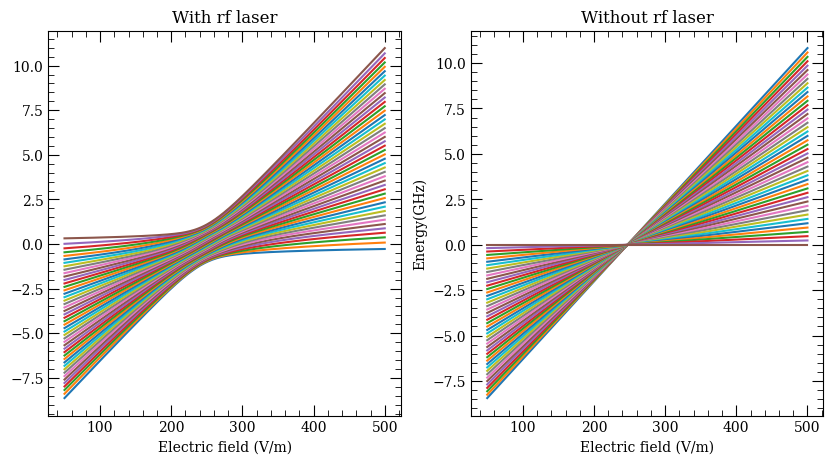

In [38]:
# Plot the ARP map
fig=plt.figure()
r = len(energys)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for n in range(r):
    plt.plot(eFieldList,energys[n],'-',label = 'state'+str(n))
plt.xlabel('Electric field (V/m)')
plt.title('With rf laser')

plt.subplot(1,2,2)
for n in range(r):
    plt.plot(eFieldList,energys0[n],'-',label = 'state'+str(n))
plt.title('Without rf laser')


plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy(GHz)')
#plt.legend()
plt.show()